In [1]:
%load_ext autoreload
%autoreload 2
from ais_dataloader import *
from gp_kernel_ship_classification_dataset import *
from gp_kernel_ship_classification_trainer import *
from gp_kernel_ship_classification_network import *
from multioutput_rbf_linear_gp import *


import ipywidgets as widgets
from IPython.display import display
from plotting_utils import *
from tqdm.notebook import tqdm
from IPython.display import clear_output
import time
import os
import torch
import gpytorch
import datetime
import seaborn as sns


# sns.set(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load Data

The cell below loads in AIS traectories from a specified date range and processes them to form a regression dataset. Modify the start and end date in date_range as desired, but leave the frequency at 'D'.

NOTE: The dataset class does not currently handle the download of the daily csv data. Users should download the desired date range by using the cli as specified in the README.

In [9]:
date_range = pd.date_range(start='2024-01-14', end='2024-01-14', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)


Combining AIS CSVs into a single df: 100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


Processing AIS data...
Removed 3961400 out of 5746483 rows due to invalid COG, SOG, LAT, or Heading values.


Standardizing trajectories for MMSI groups: 100%|██████████| 3729/3729 [00:29<00:00, 127.11it/s]


Saved processed dataset to: data/processed/processed_AIS_df_2024_01_14_2024_01_14.pkl


Scaling trajectories for each MMSI: 100%|██████████| 3729/3729 [00:01<00:00, 3628.18it/s]


===== Dataset Statistics =====
Total number of AIS messages: 1785083
Number of unique MMSIs: 3729
Date range: 2024-01-14 00:00:00 to 2024-01-14 23:59:59


Number of vessel groups: 9


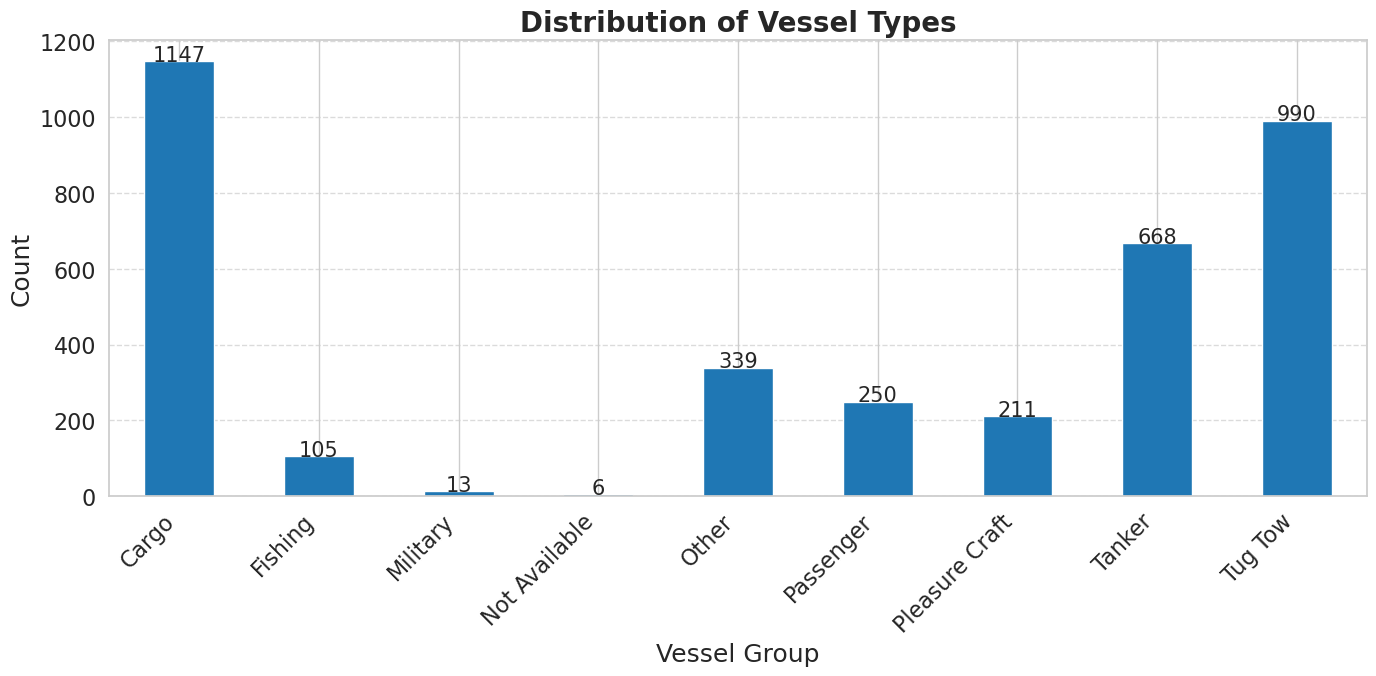

In [10]:
# Display vessel group histogram
group_counts = gp_regression_dataset.plot_vessel_group_histogram(figsize=(14, 7))


## Fit GP Models

In [13]:
# Control flag - set to True to load existing models if available, False to force retraining
reload_existing_models = True
models, likelihoods, losses = load_or_train_models(date_range, gp_regression_dataset, device, reload_existing_models)

print(f"Successfully loaded/trained {len(models)} models for {len(gp_regression_dataset)} trajectories")

Overall Progress:   2%|▏         | 63/3729 [01:25<2:10:49,  2.14s/it]

Fitting GP Models: 63/3729 completed
Average time per model: 1.35 seconds
Estimated time remaining: 01:22:34

Fitting model for MMSI 219030190 (#64/3729)


Overall Progress:   2%|▏         | 63/3729 [01:29<1:26:55,  1.42s/it]


KeyboardInterrupt: 

### View the kernel parameters of the first GPR model

In [20]:
model = next(iter(models.values()))  # Get one of the models for demonstration
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')
    
# print()
# print(model.covar_module.data_covar_module.kernels[0].lengthscale.item())
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

Parameter name: likelihood.raw_task_noises                 value = [-0.45926716923713684, -0.40939193964004517, -0.5077536702156067, -0.38612663745880127, -0.5076508522033691, -0.507537841796875]
Parameter name: likelihood.raw_noise                       value = [-0.49329403042793274]
Parameter name: mean_module.base_means.0.raw_constant      value = 0.11009286344051361
Parameter name: mean_module.base_means.1.raw_constant      value = -0.19562718272209167
Parameter name: mean_module.base_means.2.raw_constant      value = 0.0028571882285177708
Parameter name: mean_module.base_means.3.raw_constant      value = 0.002000737702473998
Parameter name: mean_module.base_means.4.raw_constant      value = 0.0010391190880909562
Parameter name: mean_module.base_means.5.raw_constant      value = 0.0004795533895958215
Parameter name: covar_module.task_covar_module.covar_factor value = [[-0.005780359264463186], [-0.0052051842212677], [-1.1244783401489258], [-0.012176335789263248], [-0.787548184394836

### Plot GP Solution

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from plotting_utils import *


def plot_for_mmsi(selected_mmsi):
    plt.close('all')
    clear_output(wait=True)
    model = models[selected_mmsi]
    likelihood = likelihoods[selected_mmsi]
    # Get the corresponding data for this MMSI
    times, state_trajectory = None, None
    for entry in gp_regression_dataset:
        if entry[0] == selected_mmsi:
            _, times, state_trajectory = entry
            break
    if times is None:
        print("No data for MMSI:", selected_mmsi)
        return

    train_X = times.clone().detach().unsqueeze(1).cpu()
    train_Y = state_trajectory.clone().detach().cpu()
    test_X = torch.linspace(times.min(), times.max(), 500).unsqueeze(1).to(device)
    test_Y = eval_model(model, likelihood, test_X)

    plot_gp(train_X, train_Y, test_X, test_Y)
    plot_single_ship_path(selected_mmsi, times, state_trajectory.cpu())

    
mmsi_dropdown = widgets.Dropdown(
    options=list(models.keys()),
    description='MMSI:',
    disabled=False,
)

widgets.interact(plot_for_mmsi, selected_mmsi=mmsi_dropdown)
    
    

interactive(children=(Dropdown(description='MMSI:', options=(3660489, 203661016, 205691000, 205717000, 2091560…

<function __main__.plot_for_mmsi(selected_mmsi)>

## Create the kernel param to ship mmsi dataset


In [64]:
kernel_classification_dataset = GPKernelShipClassificationDataset(gp_regression_dataset, models, device, scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi)
unique_group_ids = kernel_classification_dataset.get_unique_group_ids()

num_params = len(kernel_classification_dataset.get_parameter_names())

train_classification_dataset, test_classification_dataset = torch.utils.data.random_split(kernel_classification_dataset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train_classification_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_classification_dataset, batch_size=32, shuffle=False)

In [65]:
# print(num_params)
input_dim = kernel_classification_dataset.data[0][1].shape[0]
print(input_dim)

50


## Train the classification model

Using the learned kernel parameters from the GPR (for)

In [ ]:
from gp_kernel_ship_classification_network import GPKernelShipClassificationNetwork
model = GPKernelShipClassificationNetwork(input_dim=input_dim, num_classes=max(unique_group_ids) + 1).to(device)  # +1 for background class

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = GPKernelShipClassificationTrainer(model, train_loader, test_loader, criterion, optimizer, device)
trainer.train(num_epochs=1000)

GP Kernel Ship Classification Training:   1%|          | 8/1000 [00:01<02:21,  7.00it/s]

Test Accuracy: 0.3169


<Figure size 1000x800 with 0 Axes>

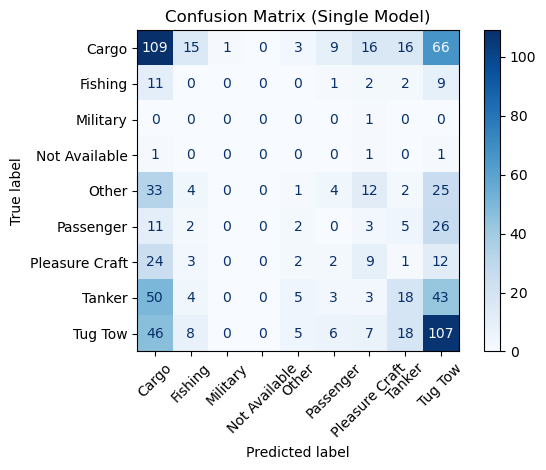

In [59]:
# Evaluate the trained model
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Calculate accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.4f}")

# Get unique classes present in predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix (Single Model)')
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the trained model
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Calculate accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.4f}")

# Get unique classes present in predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix (Single Model)')
plt.tight_layout()
plt.show()

## 5-Fold Cross Validation Classification Predictions

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import SubsetRandomSampler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure k-fold cross validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics across folds
all_preds = []
all_labels = []
fold_accuracies = []

# Get all indices
dataset_size = len(kernel_classification_dataset)
indices = list(range(dataset_size))

print(f"Starting {k_folds}-fold cross validation on {dataset_size} samples")

# K-fold cross validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(indices)):
    print(f"\nFold {fold+1}/{k_folds}")
    
    # Create data samplers for train and test
    train_sampler = SubsetRandomSampler(train_ids)
    test_sampler = SubsetRandomSampler(test_ids)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        kernel_classification_dataset, batch_size=32, 
        sampler=train_sampler
    )
    test_loader = torch.utils.data.DataLoader(
        kernel_classification_dataset, batch_size=32,
        sampler=test_sampler
    )
    
    # Get the input dimension from the dataset
    input_dim = kernel_classification_dataset.data[0][1].shape[0]
    print(f"Input dimension: {input_dim}")
    
    # Initialize model, loss function, and optimizer
    model = GPKernelShipClassificationNetwork(
        input_dim=input_dim, 
        num_classes=max(unique_group_ids) + 1
    ).to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    trainer = GPKernelShipClassificationTrainer(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    trainer.train(num_epochs=10)  # Reduced epochs for quicker k-fold demo
    
    # Evaluate on the test set
    fold_preds = []
    fold_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            mmsi, X, y = batch
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            fold_preds.extend(preds)
            fold_labels.extend(y.cpu().numpy())
    
    # Calculate fold accuracy
    fold_accuracy = np.mean(np.array(fold_preds) == np.array(fold_labels))
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")
    
    # Add to overall results
    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

# Calculate and display overall metrics
print("\n==== Cross-Validation Results ====")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Get unique classes that are actually present in the predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))

# Create class labels only for classes present in the data
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Generate and plot the aggregate confusion matrix with proper class labels
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(14, 12))



Starting 5-fold cross validation on 3850 samples

Fold 1/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 10/10 [00:00<00:00, 10.29it/s]


Fold 1 Accuracy: 0.3558

Fold 2/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 10/10 [00:00<00:00, 10.55it/s]


Fold 2 Accuracy: 0.3792

Fold 3/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 10/10 [00:00<00:00, 10.59it/s]


Fold 3 Accuracy: 0.2948

Fold 4/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 10/10 [00:00<00:00, 10.63it/s]


Fold 4 Accuracy: 0.3636

Fold 5/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 10/10 [00:00<00:00, 10.65it/s]


Fold 5 Accuracy: 0.3455

==== Cross-Validation Results ====
Mean Accuracy: 0.3478 ± 0.0287


<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

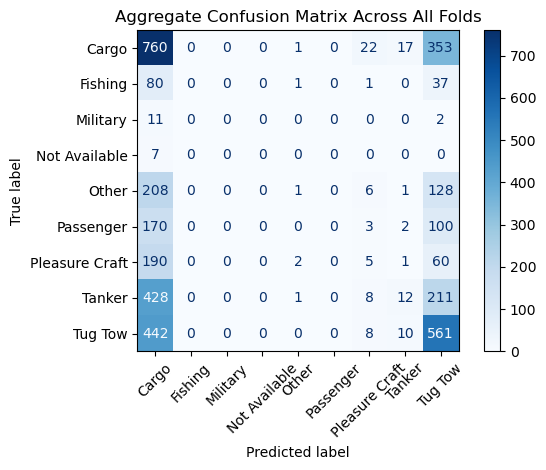


Classification Report:
                precision    recall  f1-score   support

         Cargo       0.33      0.66      0.44      1153
       Fishing       0.00      0.00      0.00       119
      Military       0.00      0.00      0.00        13
 Not Available       0.00      0.00      0.00         7
         Other       0.17      0.00      0.01       344
     Passenger       0.00      0.00      0.00       275
Pleasure Craft       0.09      0.02      0.03       258
        Tanker       0.28      0.02      0.03       660
       Tug Tow       0.39      0.55      0.45      1021

      accuracy                           0.35      3850
     macro avg       0.14      0.14      0.11      3850
  weighted avg       0.27      0.35      0.26      3850


Class Distribution in Dataset:
Cargo: 1153 samples
Fishing: 119 samples
Military: 13 samples
Not Available: 7 samples
Other: 344 samples
Passenger: 275 samples
Pleasure Craft: 258 samples
Tanker: 660 samples
Tug Tow: 1021 samples


/home/daniel/miniconda3/envs/gp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/miniconda3/envs/gp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/miniconda3/envs/gp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [ ]:

sns.reset_orig() 
# Create the confusion matrix with class names that match the matrix dimensions
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap='Blues', xticks_rotation=45)  # Rotate labels for better readability
plt.title('Aggregate Confusion Matrix Across All Folds')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Generate classification report with descriptive class names
print("\nClassification Report:")
target_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]
print(classification_report(all_labels, all_preds, labels=unique_present_classes, target_names=target_names))

# Print class distribution
print("\nClass Distribution in Dataset:")
class_counts = {}
for label in all_labels:
    class_name = id_to_vessel_group.get(label, f"Unknown ({label})")
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

for class_name, count in sorted(class_counts.items()):
    print(f"{class_name}: {count} samples")